In [17]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity
import numpy as np

import sys
sys.path.append("../src")

from fingerprinter import get_fingerprints

In [32]:
df = pd.read_csv("../data/series4_processed.csv")

active_smiles = list(df[df["bin_activity"] == 1]["smiles"])
active_mols=[Chem.MolFromSmiles(smi) for smi in active_smiles]

input_smiles="c1(Br)ccc(-c2nnc3cncc(OCCc4cc(F)c(F)cc4)n32)cc1"
input_mol=Chem.MolFromSmiles(input_smiles)


In [36]:
def mols_to_fingerprints(molecules, radius=3, useCounts=True, useFeatures=True):
    fingerprints = [AllChem.GetMorganFingerprint(
        mol,
        radius,
        useCounts=useCounts,
        useFeatures=useFeatures
    ) for mol in molecules]
    return fingerprints
    
query_fp = mols_to_fingerprints([input_mol])
ref_fps=mols_to_fingerprints(active_mols)

tanimoto=np.array([np.max(BulkTanimotoSimilarity(fp, ref_fps)) for fp in query_fp])[0]
tanimoto
tanimoto2=BulkTanimotoSimilarity(query_fp[0], ref_fps)
tanimoto2

[0.38926174496644295,
 0.4295774647887324,
 0.6311475409836066,
 0.6942148760330579,
 0.35802469135802467,
 0.34810126582278483,
 1.0,
 0.6328125,
 0.5955882352941176,
 0.6190476190476191,
 0.3710691823899371,
 0.5111111111111111,
 0.4154929577464789,
 0.39072847682119205,
 0.5223880597014925,
 0.4888888888888889,
 0.5238095238095238,
 0.8490566037735849,
 0.6349206349206349,
 0.6349206349206349,
 0.34911242603550297,
 0.45454545454545453,
 0.5785714285714286,
 0.3575757575757576,
 0.39072847682119205,
 0.7213114754098361,
 0.4925373134328358,
 0.41420118343195267,
 0.5,
 0.5294117647058824,
 0.7073170731707317,
 0.8440366972477065,
 0.8108108108108109,
 0.7964601769911505,
 0.4583333333333333,
 0.4896551724137931,
 0.5035971223021583,
 0.5625,
 0.6090225563909775,
 0.4666666666666667,
 0.49044585987261147,
 0.7096774193548387,
 0.7073170731707317,
 0.8440366972477065,
 0.616,
 0.34911242603550297,
 0.5373134328358209,
 0.4927536231884058,
 0.5230769230769231,
 0.5223880597014925,
 0.6

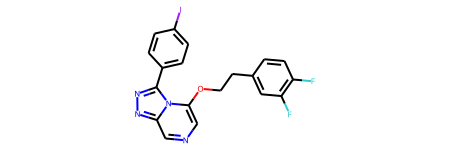

In [37]:
active_mols[6]

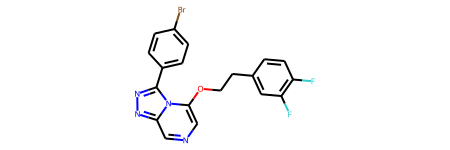

In [39]:
input_mol

In [ ]:
import numpy as np
from rdkit.Chem import DataStructs
from typing import List
from rdkit.Chem import AllChem

from scoring.component_parameters import ComponentParameters
from scoring.score_components.base_score_component import BaseScoreComponent
from scoring.score_summary import ComponentSummary


class TanimotoSimilarity(BaseScoreComponent):
    def __init__(self, parameters: ComponentParameters):
        super().__init__(parameters)
        self._fingerprints, _ = self._smiles_to_fingerprints(self.parameters.smiles)

    def calculate_score(self, molecules: List) -> ComponentSummary:
        query_fps = self._mols_to_fingerprints(molecules)
        score = self._calculate_tanimoto(query_fps, self._fingerprints)
        score_summary = ComponentSummary(total_score=score, parameters=self.parameters)
        return score_summary

    def _mols_to_fingerprints(self, molecules: List, radius=3, useCounts=True, useFeatures=True) -> []:
        fingerprints = [AllChem.GetMorganFingerprint(
            mol,
            radius,
            useCounts=useCounts,
            useFeatures=useFeatures
        ) for mol in molecules]
        return fingerprints

    def _calculate_tanimoto(self, query_fps, ref_fingerprints) -> np.array:
        # Edited by Ersilia transformer
        return np.array([np.max(DataStructs.BulkTanimotoSimilarity(fp, ref_fingerprints)) for fp in query_fps])

In [8]:
import os
import numpy as np
import pickle

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.DataStructs import cDataStructs


class RAScorerXGB:
    """
    Prediction of machine learned retrosynthetic accessibility score
    The RAScore is calculated based on the predictions made on 200,000 compounds sampled from ChEMBL.
    The compounds were subjected to retrosynthetic analysis using a CASP tool (AiZynthfinder) and output used as labels to train a binary classifier.
    If the compounds are ChEMBL like use the RAscore models.
    Else if the compounds are more exotic, are small fragments, or closely resemble GDB. GBDscore may give a better result.
    This class facilitates predictions from the resulting model.
    """

    def __init__(self, model_path=None):
        """
        Loads the model.
        :param model_path: path to the XGBoost model (.pkl) file
        :type model_path: pkl
        """
        self.xgb_model = pickle.load(open(os.path.abspath(model_path), "rb"))

    def ecfp(self, smiles):
        """
        Converts SMILES into a counted ECFP6 vector with features.
        :param smiles: SMILES representation of the moelcule of interest
        :type smiles: str
        :return: ECFP6 counted vector with features
        :rtype: np.array
        """
        mol = Chem.MolFromSmiles(smiles)
        fp = AllChem.GetMorganFingerprint(mol, 3, useCounts=True, useFeatures=False)
        size = 2048
        arr = np.zeros((size,), np.int32)
        for idx, v in fp.GetNonzeroElements().items():
            nidx = idx % size
            arr[nidx] += int(v)
        return arr

    def predict(self, smiles):
        """
        Predicts score from SMILES.
        :param smiles: SMILES representation of the moelcule of interest
        :type smiles: str
        :return: score
        :rtype: float
        """
        arr = self.ecfp(smiles)
        proba = self.xgb_model.predict_proba(arr.reshape(1, -1))
        return proba[0][1]

In [9]:
model_path="../model/RA_model.pkl"

In [10]:
ra = RAScorerXGB(model_path)

In [7]:
!pip install xgboost

In [11]:
ra.predict("CCCOCC")

AttributeError: 'XGBClassifier' object has no attribute 'use_label_encoder'

ERROR: Could not find a version that satisfies the requirement xbgoost==1.2 (from versions: none)
ERROR: No matching distribution found for xbgoost==1.2
